In [44]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Get project files
#!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

#!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [46]:
# 3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Set up normalization for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths
train_dir = 'cats_and_dogs/train'
validation_dir = 'cats_and_dogs/validation'
test_dir = 'cats_and_dogs'

# Create training data generator
train_image_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary'     # Binary classification (cats vs dogs)
)

# Create validation data generator
validation_image_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Create test data generator
test_image_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    batch_size=1,  # Batch size can be set to 1 for prediction
    classes=['test'],  # No labels in the test data
    shuffle=False     # Important: keep the order of test images unchanged
)

# Assign the data generators to variables if needed
train_data_gen = train_image_generator
val_data_gen = validation_image_generator
test_data_gen = test_image_generator

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


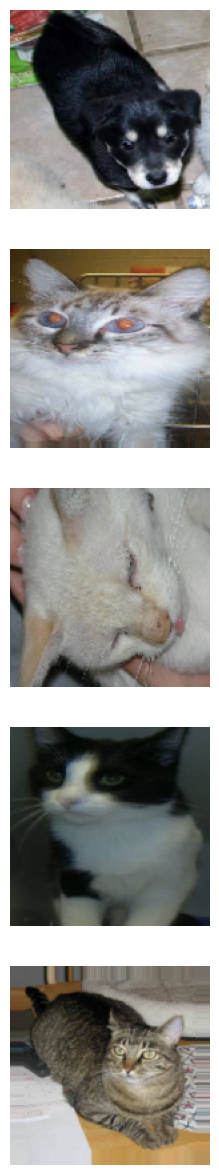

In [47]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [48]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           validation_split = .2)

Found 2000 images belonging to 2 classes.


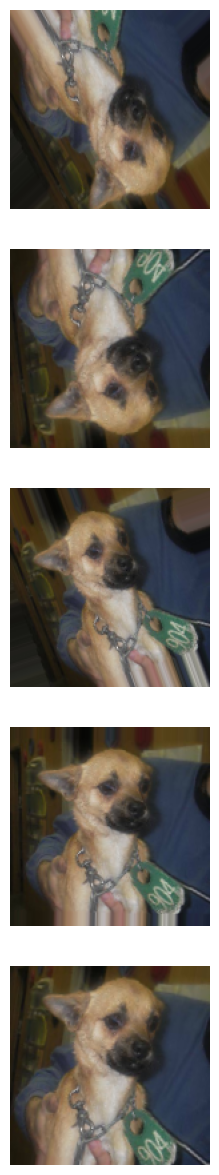

In [49]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [50]:
#7
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,930 (9.39 MB)

 Trainable params: 2,460,930 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# 8
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 915ms/step - accuracy: 0.4790 - loss: 2.2546 - val_accuracy: 0.6473 - val_loss: 0.6853
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4922 - loss: 0.6941 - val_accuracy: 0.6027 - val_loss: 0.6819
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 870ms/step - accuracy: 0.5488 - loss: 0.6899 - val_accuracy: 0.5893 - val_loss: 0.6699
Epoch 4/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - accuracy: 0.5375 - loss: 0.6757

2024-08-05 20:52:49.992545: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5375 - loss: 0.6757 - val_accuracy: 0.5580 - val_loss: 0.6726
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 913ms/step - accuracy: 0.5709 - loss: 0.6767 - val_accuracy: 0.6442 - val_loss: 0.6343
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6406 - loss: 0.6573 - val_accuracy: 0.5893 - val_loss: 0.6563
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step - accuracy: 0.5682 - loss: 0.6661 - val_accuracy: 0.6205 - val_loss: 0.6431
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5781 - loss: 0.6637 - val_accuracy: 0.6562 - val_loss: 0.6313
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 914ms/step - accuracy: 0.6040 - loss: 0.6503 - val_accuracy: 0.5982 - val_loss: 0.6393
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6484 - loss: 0.6124 - val_accuracy: 0.5865 - val_loss: 0.6441
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 977ms/step - accuracy: 0.6155 - loss: 0.6318 - val_accuracy: 0.6250 - va

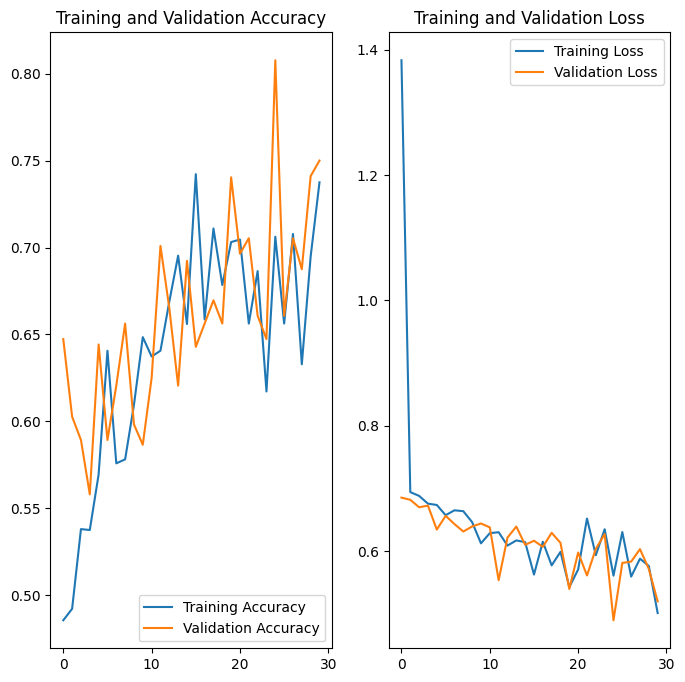

In [52]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
# Get one batch of test images
test_images, _ = next(test_data_gen)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
print(probabilities)
#plotImages(test_images, probabilities=probabilities)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1
 1 1 1 1 0 1 1 0 0 1 0 0 0]


In [54]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
